In [1]:
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib import animation as am
from matplotlib import cm
from scipy.integrate import ode 
from kuramoto import * # import the kuramoto classes from file 
from utils import *
from scipy import stats, optimize
from matplotlib import cm

## This notebook contains code for both running the simulation and plotting the data. To run the simulations, run all the cells. To plot the data with the saved .npy files, simply run the cells that load the data, followed by the cells that plot them. 

## Kymograph 

In [2]:
# Set up model parameters 
epsilon = 1
eta = -0.44
sigma = 0.09
mean_omega = 0
noise = np.sqrt(0.45**2-sigma**2)


# Set up simulation parameters 
L = 200
T = 1e4 # total time of the simulation 
n_frames = T # number of time points recorded in the end 
init = np.zeros(L)
grad = 1.3
grads = [-grad, grad]
seed = 10 

In [19]:
model = KuramotoVF(epsilon, eta, sigma, mean_omega, noise=noise, BC='grad', grad=grads)
model.initialise(L, T, n_frames, init=init, seed=seed)
model.evolve(dt=1e-2) 

100%|████████████████████████████████████| 10000/10000 [00:23<00:00, 425.48it/s]


In [20]:
np.save('Sims/data_sigma={}_eta={}_noise={}.npy'.format(sigma, eta, noise), model.res)
res = model.res

In [3]:
res = np.load('Sims/data_sigma={}_eta={}_noise={}.npy'.format(sigma, eta, noise))

0.3653014713476504


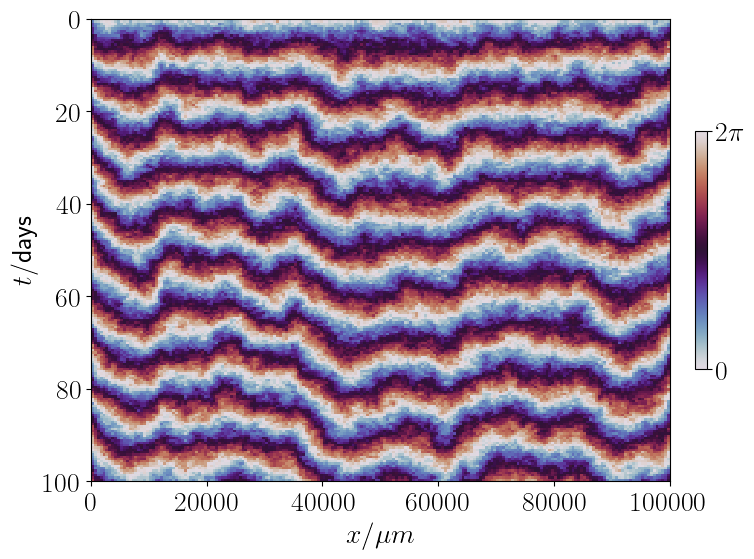

In [12]:
N = 200
epsilon_true = 0.2
scale= 10
omega_extra = 2*np.pi/8.6/epsilon_true/scale
print(omega_extra)

phases = np.copy(res[:N, :])
phases += np.arange(N)[:, np.newaxis]*omega_extra

plt.figure(figsize=(8, 6))
plt.rc('font', size=20)
plt.rc('text', usetex=True)
im = plt.imshow(phases %(2*np.pi), cmap='twilight', interpolation='none', vmin=0, vmax=2*np.pi, extent=[0, L*500, N/scale/epsilon_true, 0], aspect=800)
cbar = plt.colorbar(im, fraction=0.019, pad=0.04)
cbar.set_ticks([0, 2*np.pi])
cbar.set_ticklabels([r'$0$', r'$2\pi$'])
plt.xlabel(r'$x/\mu m$')
plt.ylabel(r'$t$/days')
plt.tight_layout()
plt.savefig('Figures/kymograph_sim_init.pdf')
plt.show() 

0.3653014713476504


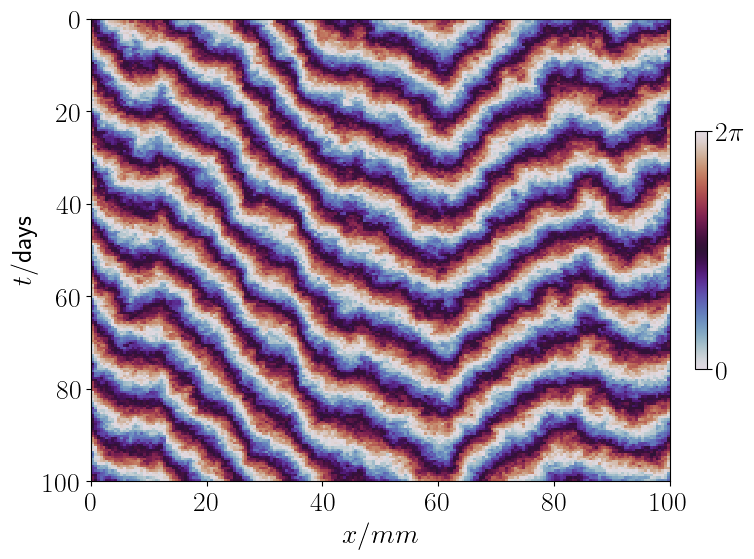

In [5]:
N = 200
epsilon_true = 0.2
scale= 10
omega_extra = 2*np.pi/8.6/epsilon_true/scale
print(omega_extra)

phases = np.copy(res[-N:, :])
phases += np.arange(N)[:, np.newaxis]*omega_extra

plt.figure(figsize=(8, 6))
plt.rc('font', size=20)
plt.rc('text', usetex=True)
im = plt.imshow(phases %(2*np.pi), cmap='twilight', interpolation='none', vmin=0, vmax=2*np.pi, extent=[0, L*0.5, N/scale/epsilon_true, 0], aspect=0.8)
cbar = plt.colorbar(im, fraction=0.019, pad=0.04)
cbar.set_ticks([0, 2*np.pi])
cbar.set_ticklabels([r'$0$', r'$2\pi$'])
plt.xlabel(r'$x/mm$')
plt.ylabel(r'$t$/days')
plt.tight_layout()
plt.savefig('Figures/kymograph_sim.pdf')
plt.show() 

## Test robustness of the model against initial conditions 

In [6]:
# Set up model parameters 
epsilon = 1
eta = -0.44
sigma = 0.09
mean_omega = 0
noise = 0.44 


# Set up simulation parameters 
L = 200
grad = 1.3
grads = [-grad, grad]

In [8]:
T = 5e3
n_frames = int(T) 
seed = 10

data = [] 
for i in range(5):  
    init = np.zeros(L) + np.random.normal(size=L)
    model = KuramotoVF(epsilon, eta, sigma, mean_omega, noise=noise, BC='grad', grad=grads)
    model.initialise(L, T, n_frames, init=init, seed=seed)
    model.evolve(dt=1e-2) 
    
    data.append(model.res)

100%|██████████████████████████████████████| 5000/5000 [00:11<00:00, 426.80it/s]


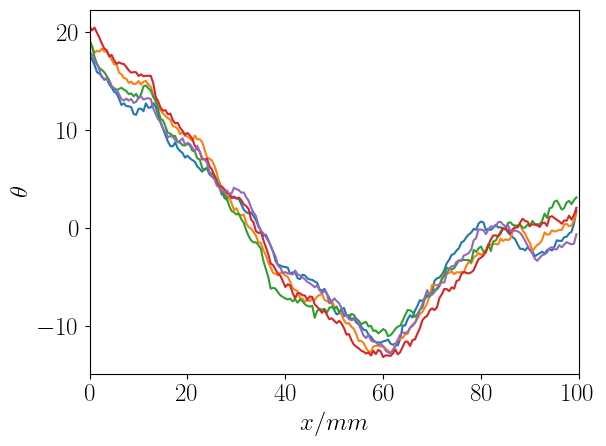

In [10]:
x = np.arange(L)*0.5

plt.rc('font', size=18)
plt.rc('text', usetex=True)

for d in data: 
    theta = d[-1]
    shift(theta)
    theta -= np.mean(theta)
    plt.plot(x, theta)
plt.xlim([0, 200*0.5])
plt.xlabel(r'$x/mm$')
plt.ylabel(r'$\theta$')
plt.tight_layout()
plt.savefig('Figures/init.pdf')
plt.show() 

In [11]:
T = 5e3
n_frames = int(T) 
seed = 10

x = np.arange(L)
mid = L/2 
wave = np.abs(x-mid)/L*np.pi

data = [] 
inits = [] 
for s in np.linspace(-1, 1, 5):  
    init = np.zeros(L) + wave*s*10
    inits.append(init) 
    model = KuramotoVF(epsilon, eta, sigma, mean_omega, noise=noise, BC='grad', grad=grads)
    model.initialise(L, T, n_frames, init=init, seed=seed)
    model.evolve(dt=1e-2) 
    
    data.append(model.res)

100%|██████████████████████████████████████| 5000/5000 [00:11<00:00, 422.01it/s]


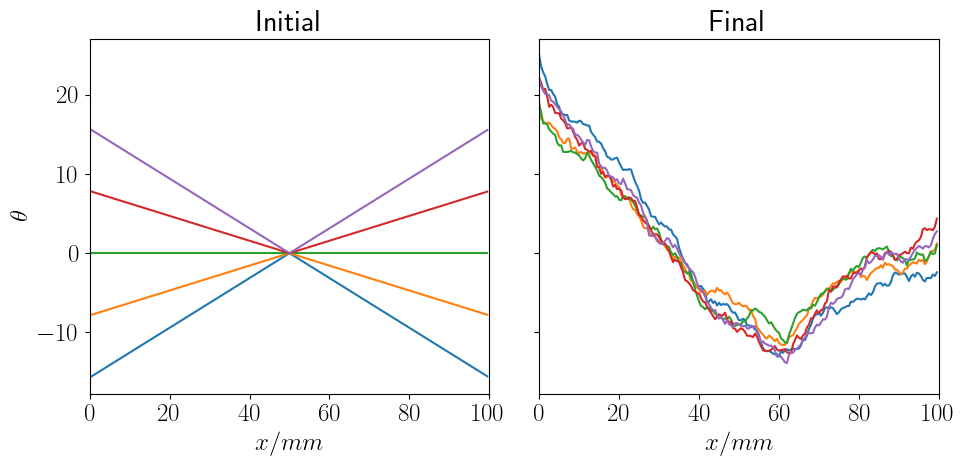

In [13]:
x = np.arange(L)*0.5

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

for (d, init) in zip(data, inits): 
    theta = d[-1]
    shift(theta)
    theta -= np.mean(theta)
    axes[1].plot(x, theta)
    axes[0].plot(x, init)
axes[0].set_xlim([0, 200*0.5])
axes[0].set_xlabel(r'$x/mm$')
axes[1].set_xlabel(r'$x/mm$')
axes[0].set_ylabel(r'$\theta$')
axes[0].set_title(r'Initial')
axes[1].set_title(r'Final')
plt.tight_layout()
plt.savefig('Figures/wave_init.pdf')
plt.show() 

## Plot phase diagram in eta and sigma 

In [2]:
# Set up model parameters 
epsilon = 1
mean_omega = 0
noise = 0.44


# Set up simulation parameters 
L = 200
T = 5e3 # total time of the simulation 
n_frames = int(T) # number of time points recorded in the end 
init = np.zeros(L)
grad = -1.3
grads = [-grad, grad]
seeds = [10]*2

sigmas = [0, 0.05, 0.1, 0.2, 0.5] 
etas = [-1, -0.44, 0, 0.44, 1] 

In [3]:
data = [] 
for sigma in sigmas: 
    for eta in etas: 
        for seed in seeds: 
            model = KuramotoVF(epsilon, eta, sigma, mean_omega, noise=noise, BC='grad', grad=grads)
            model.initialise(L, T, n_frames, init=init, seed=seed)
            model.evolve(dt=1e-2) 

            phases = np.copy(model.res[-1]) % (2*np.pi)
            shift(phases)
            data.append(phases)

100%|██████████████████████████████████████| 5000/5000 [00:12<00:00, 408.54it/s]


In [4]:
np.save('Sims/SSK_phase_diagram_g={}.npy'.format(grad), data)

In [8]:
data = np.load('Sims/SSK_phase_diagram_g={}.npy'.format(grad))

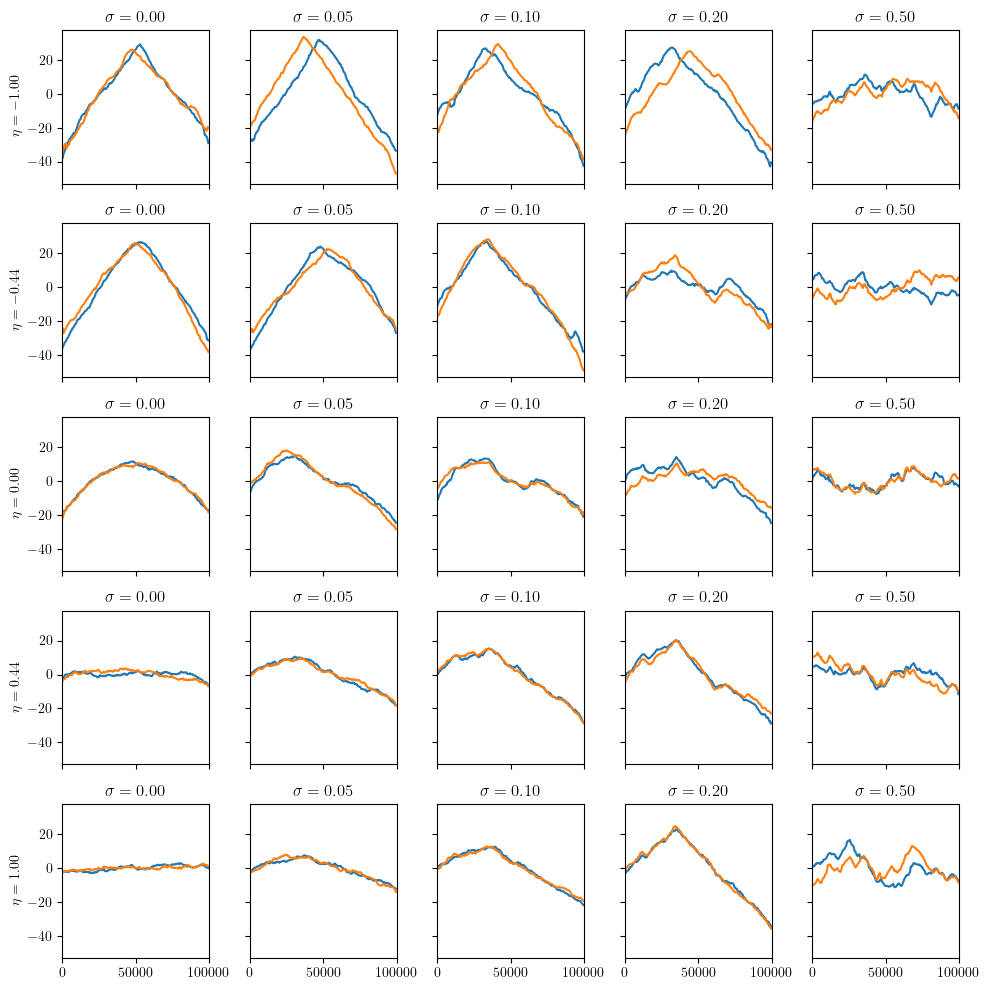

In [6]:
fig, axes = plt.subplots(len(etas), len(sigmas), sharex=True, sharey=True, figsize=(len(sigmas)*2, len(etas)*2))

x = np.arange(L)*500

plt.rc('font', size=10)
plt.rc('text', usetex=True)

i = 0 
for (a, sigma) in enumerate(sigmas):
    for (b, eta) in enumerate(etas): 
        for (n, seed) in enumerate(seeds): 
            theta = data[i]
            theta = theta - np.mean(theta)
            axes[b, a].plot(x, theta, color=plt.cm.tab10(n))
            i += 1

        axes[b, a].set_title(r'$\sigma={:.2f}$'.format(sigma))
        
axes[0, 0].set_xlim([0,200*500])
for i in range(len(etas)):
    axes[i, 0].set_ylabel(r'$\eta={:.2f}$'.format(etas[i]))
plt.tight_layout()    
plt.savefig('Figures/param_sweep_g={}.pdf'.format(grad))
plt.show() 